In [1]:
# 基础库
import pandas as pd
import numpy as np

# RDKit：做分子指纹
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# 机器学习
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)


In [2]:
# 注意路径：你之前在 minGPT 里用的是 "minGPT/htp_md.csv"
csv_path = "./minGPT/htp_md.csv"

df = pd.read_csv(csv_path, sep="\t")  # 这个文件在 PolyGen 里是制表符分隔
print(df.head())
print(df.dtypes)
print(df["conductivity"].value_counts())


                         mol_smiles  conductivity
0      NC(=O)CSCC(CO[Cu])OC(=O)[Au]             1
1  CCC(F)C(=O)NC(CO[Cu])COC(=O)[Au]             0
2       CCSCCN(CCN[Cu])CCOC(=O)[Au]             1
3     C#CCN(CCOCCO[Cu])CCOC(=O)[Au]             1
4     CCC(COC(=O)[Au])C(=O)NCCO[Cu]             0
mol_smiles      object
conductivity     int64
dtype: object
conductivity
1    5704
0    5704
Name: count, dtype: int64


In [3]:
# SMILES → Morgan fingerprint 特征
# 我们写一个帮助函数，把每个 SMILES 变成 2048-d 的 bit 向量（和你在 PolyGen 指标里用的是同一类 fingerprint：radius=2, nBits=2048）。
def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    """Convert a SMILES string to a Morgan fingerprint (numpy array)."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# 对整个数据集做特征转换
X_list = []
y_list = []

for smi, label in zip(df["mol_smiles"], df["conductivity"]):
    fp = smiles_to_morgan(smi)
    if fp is not None:
        X_list.append(fp)
        y_list.append(label)

X = np.vstack(X_list)
y = np.array(y_list)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerator
[17:37:12] DEPRECATION WARNING: please use MorganGenerat

Feature matrix shape: (11408, 2048)
Labels shape: (11408,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 保持 0/1 比例一致
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# 定义一个简单的 RandomForest baseline
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


Train size: 9126
Test size: 2282


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [5]:
# 预测
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# 基本指标
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy  : {acc:.3f}")
print(f"F1-score  : {f1:.3f}")
print(f"ROC-AUC   : {auc:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy  : 0.990
F1-score  : 0.990
ROC-AUC   : 1.000

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1141
           1       0.98      1.00      0.99      1141

    accuracy                           0.99      2282
   macro avg       0.99      0.99      0.99      2282
weighted avg       0.99      0.99      0.99      2282

Confusion matrix:
[[1119   22]
 [   0 1141]]


In [ ]:
# !pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.3 MB/s eta 0:00:00a 0:00:01


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 定义 XGBoost 模型
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

# 训练
xgb.fit(X_train, y_train)

# 预测
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# 评估
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"XGBoost Accuracy : {acc_xgb:.3f}")
print(f"XGBoost F1-score : {f1_xgb:.3f}")
print(f"XGBoost ROC-AUC  : {auc_xgb:.3f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy : 0.968
XGBoost F1-score : 0.969
XGBoost ROC-AUC  : 0.994

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1141
           1       0.94      1.00      0.97      1141

    accuracy                           0.97      2282
   macro avg       0.97      0.97      0.97      2282
weighted avg       0.97      0.97      0.97      2282

Confusion matrix:
[[1068   73]
 [   0 1141]]


## Alignment

In [9]:
import json

with open("generated_high.json") as f:
    high_results = json.load(f)

with open("generated_low.json") as f:
    low_results = json.load(f)


In [10]:
# high_results, low_results 应该已经存在；如果你是从 json 读入，就先 json.load 一下

X_high = []
X_low = []

for smi in high_results:
    fp = smiles_to_morgan(smi)
    if fp is not None:
        X_high.append(fp)

for smi in low_results:
    fp = smiles_to_morgan(smi)
    if fp is not None:
        X_low.append(fp)

X_high = np.vstack(X_high)
X_low = np.vstack(X_low)

print("High set shape:", X_high.shape)
print("Low  set shape:", X_low.shape)


High set shape: (96, 2048)
Low  set shape: (81, 2048)


[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerator
[18:55:18] DEPRECATION WARNING: please use MorganGenerat

In [11]:
# 确认 rf 已经训练好；如果在这个 kernel 里还没跑 RF baseline，需要先重新 fit 一下

high_proba = rf.predict_proba(X_high)[:, 1]  # P(high)
low_proba  = rf.predict_proba(X_low)[:, 1]   # P(high)

print(f"Mean P(high) for high-prompt samples : {high_proba.mean():.3f}")
print(f"Mean P(high) for low-prompt samples  : {low_proba .mean():.3f}")


Mean P(high) for high-prompt samples : 0.665
Mean P(high) for low-prompt samples  : 0.061


直观解释：
high_proba.mean() 越接近 1，说明 high prompt 生成的分子越被 RF 认为是“高导电”
low_proba.mean() 越接近 0，说明 low prompt 生成的分子越被 RF 认为是“低导电”
两者差越大，conditional control 越好

In [12]:
# Alignment AUC

y_scores = np.concatenate([high_proba, low_proba])
y_labels = np.concatenate([
    np.ones_like(high_proba),  # high prompt -> label 1
    np.zeros_like(low_proba)   # low prompt  -> label 0
])

alignment_auc = roc_auc_score(y_labels, y_scores)
print(f"Property alignment AUC (RF): {alignment_auc:.3f}")


Property alignment AUC (RF): 0.957


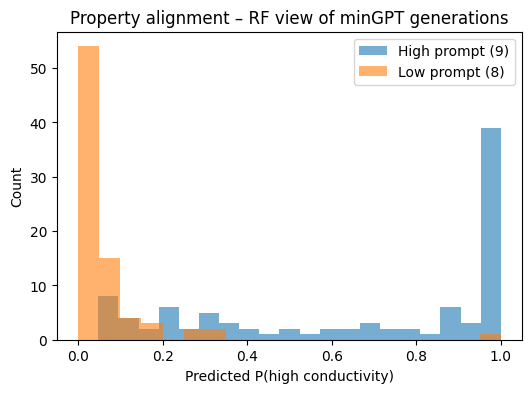

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(high_proba, bins=20, alpha=0.6, label="High prompt (9)")
plt.hist(low_proba,  bins=20, alpha=0.6, label="Low prompt (8)")
plt.xlabel("Predicted P(high conductivity)")
plt.ylabel("Count")
plt.legend()
plt.title("Property alignment – RF view of minGPT generations")
plt.show()


## 试试gpt4o

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

In [17]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [26]:
# 这个函数能：给 GPT-4o 一个 prompt, 自动解析成 SMILES 列表, 可生成任意数量的 SMILES（虽然 GPT-4o 每次输出 token 有限制）
def generate_gpt4o_smiles(prompt, n=30, model="gpt-4o-mini"):
    """
    Generate SMILES using GPT-4o/Mini with a few-shot prompt.
    Returns a list of SMILES strings.
    """
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=1.0,
        max_tokens=2000  # 允许生成更长输出
    )

    # 兼容 openai v1 SDK：content 是属性不是 dict
    text = response.choices[0].message.content

    # 每行一个 SMILES，去掉空行和奇怪前缀
    smiles = []
    for line in text.split("\n"):
        line = line.strip()
        if not line:
            continue
        # 去掉 "1." "2." 这种可能的开头
        if line[0].isdigit() and line[1] == ".":
            line = line[2:].strip()
        smiles.append(line)

    # 限制返回 n 个（有些时候 GPT 会生成超过 30 ）
    return smiles[:n]


In [ ]:
# 准备 Few-shot High conductivity prompt
# 生成高导电 SMILES
high_prompt_gpt4o = """
You are a polymer electrolyte design assistant. 
Generate 100 unique polymer-like molecules in SMILES format with HIGH ionic conductivity.

Requirements:
- Each molecule must contain exactly one [Cu] and one [Au].
- Include polar groups (O, N, CO).
- Must be valid SMILES, one per line.
- Must not repeat the examples.

Examples:
NC(=O)CSCC(CO[Cu])OC(=O)[Au]
CCN(CCO[Cu])CCC(CO)OC(=O)[Au]
OCNCCC(COC[Cu])COC(=O)[Au]

Now generate 100 new high-conductivity polymer molecules.
Return ONLY SMILES lines, nothing else.
"""

gpt4o_high_results = generate_gpt4o_smiles(high_prompt_gpt4o, n=100)
gpt4o_high_results[:10]


['O=C(CO)N(CCO[Cu])C(CO)[Au]',
 'CC(CO[Cu])OCC(C(=O)N)C(=O)[Au]',
 'N(COC(C[Cu])CO)C(=O)C[Au]',
 'CO(CO[Cu])C(=O)N(CC)C(=O)[Au]',
 'O=C(COC[Cu])N(CC(CO)C)C[Au]',
 'C(=O)N(CCO)C(CSO[Cu])C[Au]',
 'OC(CCO[Cu])CC(=O)N(C)C[Au]',
 'COC(CO[Cu])C(=O)NC(CO)C[Au]',
 'O=C(CO[Cu])N(CC)C(C(=O)O)[Au]',
 '10. CC(CO[Cu])O(C(=O)C)N(CC)C[Au]']

In [63]:
# 生成低导电 SMILES
low_prompt_gpt4o = """
You are a SMILES generator for polymer electrolytes.

Task:
Generate 100 VALID SMILES strings that have LOW ionic conductivity.

Hard constraints (must ALL be satisfied):
1. Each SMILES must contain EXACTLY one [Cu] and one [Au].
2. The backbone must be HYDROPHOBIC:
   - Use mainly C and H atoms.
   - MAY include at most ONE oxygen (O) OR ONE nitrogen (N), but not both.
3. MUST NOT contain more than one polar group (=O or -O- or -N-).
4. No whitespace, no numbering, no comments.
5. One SMILES per line.
6. Return ONLY SMILES lines.

Soft constraints (increase likelihood of low conductivity):
- Prefer long aliphatic carbon chains.
- Keep heteroatoms near the chain ends.

Examples (valid patterns):
CCCCCCC(C)CCO[Cu]CCC[Au]
CCC(C)CCCCCCC(=O)C[Cu]C[Au]
CCCCCCCCCN[Cu]CCCC(=O)[Au]

Now generate 100 new low-conductivity polymer molecules.
Return ONLY SMILES, no explanations.

"""

gpt4o_low_results = generate_gpt4o_smiles(low_prompt_gpt4o, n=100)
gpt4o_low_results[:10]

['CCCCCCCCCCCCCCCCCC[Cu]CCCCCCCCCC[Au]',
 'CCCCCCCCC(C)CCCCCCCC[Cu]CCCCCC[Au]',
 'CCCCCCCCCCCCCC[Cu]CCCCCCCCCCCCCC[Au]',
 'CCCCCCCCCCCC[Cu]CCCCCCCCCCCCCCCC[Au]',
 'CCCCCCCCCCCCC[Cu]CCCCCCCC(=O)CCCCCC[Au]',
 'CCCCCCCCCC[Cu]CCC(C)(C)CCCCCCCCCC[Au]',
 'CCCCCCCCCCCCC(C)CCCC[Cu]CCCCCCCC[Au]',
 'CCCCCCCCCCCCCCCCC[Cu]CCCCC(=O)CCCCCC[Au]',
 'C(C)CCCCCCCCCCCCC[Cu]CCCCCCCC[Au]',
 'CCCCCCCCCCCCC[Cu]CCCCCCCCC(C)CCCCCC[Au]']

In [64]:
import re

def clean_gpt4o_output(raw_list):
    cleaned = []
    
    for line in raw_list:
        line = line.strip()
        if not line:
            continue

        # 1) 去掉前面的编号，比如 "10. "、"3. "
        #    匹配：开头若干空格 + 数字 + 点 + 若干空格
        line = re.sub(r'^\s*\d+\.\s*', '', line)

        # 2) 必须包含 Cu 和 Au（这一条我们保留）
        if "[Cu]" not in line or "[Au]" not in line:
            continue

        # 3) 过滤明显不是 SMILES 的行（包含长英文单词的）
        #   现在你的 prompt 已经规定“只输出 SMILES”，
        #   这一条触发的情况应该已经很少了
        if re.search(r"[A-Za-z]{3,}", line) and not re.search(r"[A-Z][a-z]?", line):
            continue

        # 4) 不允许空格、逗号、分号等
        if re.search(r"[ ,:;]", line):
            continue

        # 5) 基本字符检查：只允许原子、数字、括号、键号
        if not re.match(r"^[A-Za-z0-9\[\]\(\)=#]+$", line):
            continue

        cleaned.append(line)

    return cleaned


gpt4o_high_clean = clean_gpt4o_output(gpt4o_high_results)
gpt4o_low_clean  = clean_gpt4o_output(gpt4o_low_results)

len(gpt4o_high_clean), len(gpt4o_low_clean)


(89, 74)

In [65]:
with open("gpt4o_high_clean.json", "w") as f:
    json.dump(gpt4o_high_clean, f)

with open("gpt4o_low_clean.json", "w") as f:
    json.dump(gpt4o_low_clean, f)

In [66]:
from minGPT.metrics import (
    check_novelty,
    validate_mol,
    has_two_ends,
    calculateScore,
    calculate_morgan_fingerprint,
    calculate_diversity,
)
from rdkit import Chem
from rdkit.DataStructs import TanimotoSimilarity
import pandas as pd
import numpy as np


In [61]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.DataStructs import TanimotoSimilarity

from minGPT.metrics import (
    check_novelty,
    validate_mol,
    has_two_ends,
    calculateScore,
    calculate_morgan_fingerprint,
    calculate_diversity
)

def evaluate_smiles_list(gen_smiles_list, train_smiles_list):
    """
    完全对齐 pipeline.evaluate() 的 6 个指标计算方法。
    """

    # 转 DataFrame
    df_train = pd.DataFrame({"mol_smiles": train_smiles_list})
    df_gen   = pd.DataFrame({"mol_smiles": gen_smiles_list})
    num_samples = len(df_gen)
    if num_samples == 0:
        raise ValueError("No generated SMILES provided.")

    # -------------------------------
    # Novelty & Uniqueness（完全对齐）
    # -------------------------------
    df_train["duplicate"] = df_train["mol_smiles"].duplicated()
    df_train = df_train[df_train["duplicate"] == False]

    df_gen["duplicate"] = df_gen["mol_smiles"].duplicated()
    uniqueness = 1 - len(df_gen[df_gen["duplicate"] == True]) / num_samples

    # novelty：会添加 "diversity" 列
    df_gen_2 = check_novelty(df_gen.copy(), df_train, "mol_smiles")

    count_not_novel = df_gen_2["mol_smiles"][df_gen_2["diversity"] != "novel"].count()
    novelty = 1 - count_not_novel / num_samples

    # -------------------------------
    # Validity（需要基于 df_gen_2）
    # -------------------------------
    df_gen_valid = validate_mol(df_gen_2.copy(), column_name="mol_smiles")
    df_gen_valid = has_two_ends(df_gen_valid)

    df_valid = df_gen_valid.loc[
        (df_gen_valid["validity"] == "ok")
        & (df_gen_valid["has_two_ends"] == True)
    ]
    validity = len(df_valid) / num_samples

    # -------------------------------
    # Clean set（用于 SA, similarity, diversity）
    # -------------------------------
    df_clean = df_gen_valid.loc[
        (df_gen_valid["duplicate"] == False)
        & (df_gen_valid["diversity"] == "novel")
        & (df_gen_valid["validity"] == "ok")
        & (df_gen_valid["has_two_ends"] == True)
    ]

    # -------------------------------
    # Synthesizability
    # -------------------------------
    if len(df_clean) > 0:
        sa_scores_clean = [
            calculateScore(Chem.MolFromSmiles(s))
            for s in df_clean["mol_smiles"]
        ]
        synthesizability = len([x for x in sa_scores_clean if x < 5]) / len(df_clean)
    else:
        synthesizability = np.nan

    # -------------------------------
    # Similarity & Diversity
    # -------------------------------
    if len(df_clean) > 0:
        morgan_gen   = calculate_morgan_fingerprint(df_clean["mol_smiles"])
        morgan_train = calculate_morgan_fingerprint(df_train["mol_smiles"])

        # similarity
        tanimoto_similarity = []
        for i in range(len(df_clean["mol_smiles"])):
            f1 = morgan_gen[i]
            scores = [TanimotoSimilarity(f1, f2) for f2 in morgan_train]
            tanimoto_similarity.append(np.mean(scores))
        similarity = np.mean(tanimoto_similarity)

        # diversity
        _, diversity = calculate_diversity(df_clean["mol_smiles"].to_list())
    else:
        similarity = np.nan
        diversity = np.nan

    return uniqueness, novelty, validity, synthesizability, similarity, diversity



In [67]:
# 训练集 SMILES（和 minGPT 一样，用 htp_md.csv）
train_smiles = pd.read_csv("minGPT/htp_md.csv", sep="\t")["mol_smiles"].astype(str).tolist()
# 你已经有：
# gpt4o_high_results, gpt4o_low_results  （都是 list[str]）
print("GPT-4o HIGH:", evaluate_smiles_list(gpt4o_high_clean, train_smiles))
print("GPT-4o LOW :", evaluate_smiles_list(gpt4o_low_clean,  train_smiles))


GPT-4o HIGH: (1.0, 1.0, 0.6966292134831461, 0.24193548387096775, 0.20189141899835783, 0.7426618090046858)
GPT-4o LOW : (0.9864864864864865, 1.0, 0.013513513513513514, 1.0, 0.16446945225890694, nan)


In [71]:
import json

# 保存高导电
with open("gpt4o_high_clean.json", "w") as f:
    json.dump(gpt4o_high_clean, f)

# 保存低导电
with open("gpt4o_low_clean.json", "w") as f:
    json.dump(gpt4o_low_clean, f)

print("Saved!")

Saved!


In [72]:
import numpy as np

# 假设你已经有：
# - 函数 smiles_to_morgan(smi)  （和 RF baseline 里的一样，radius=2, nBits=2048）
# - 训练好的 RandomForestClassifier 对象 rf

# 1) 把 GPT-4o 生成的 SMILES 转成 Morgan 指纹
X_high = []
X_low  = []

for smi in gpt4o_high_clean:
    fp = smiles_to_morgan(smi)
    if fp is not None:
        X_high.append(fp)

for smi in gpt4o_low_clean:
    fp = smiles_to_morgan(smi)
    if fp is not None:
        X_low.append(fp)

X_high = np.vstack(X_high)
X_low  = np.vstack(X_low)

print("GPT-4o high set shape:", X_high.shape)
print("GPT-4o low  set shape:", X_low.shape)

# 2) 用 RF 预测 “高导电性” 概率
high_proba = rf.predict_proba(X_high)[:, 1]   # P(high)
low_proba  = rf.predict_proba(X_low)[:, 1]    # P(high)

print(f"Mean P(high) for high-prompt samples : {high_proba.mean():.3f}")
print(f"Mean P(high) for low-prompt  samples : {low_proba.mean():.3f}")


GPT-4o high set shape: (64, 2048)
GPT-4o low  set shape: (73, 2048)
Mean P(high) for high-prompt samples : 0.101
Mean P(high) for low-prompt  samples : 0.014


Property alignment AUC (RF, GPT-4o): 0.959


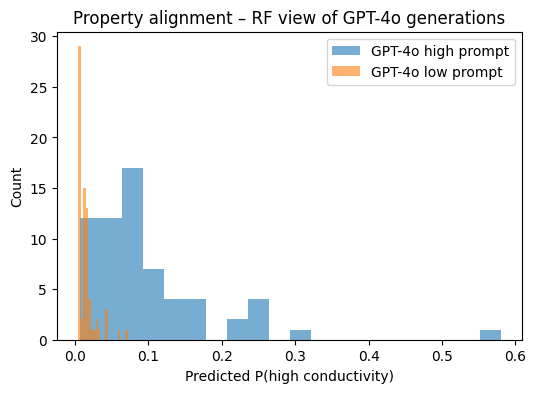

In [73]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Alignment AUC
y_scores = np.concatenate([high_proba, low_proba])
y_labels = np.concatenate([
    np.ones_like(high_proba),   # high prompt → label 1
    np.zeros_like(low_proba)    # low prompt  → label 0
])

alignment_auc = roc_auc_score(y_labels, y_scores)
print(f"Property alignment AUC (RF, GPT-4o): {alignment_auc:.3f}")

# 直方图
plt.figure(figsize=(6,4))
plt.hist(high_proba, bins=20, alpha=0.6, label="GPT-4o high prompt")
plt.hist(low_proba,  bins=20, alpha=0.6, label="GPT-4o low prompt")
plt.xlabel("Predicted P(high conductivity)")
plt.ylabel("Count")
plt.title("Property alignment – RF view of GPT-4o generations")
plt.legend()
plt.show()


## Report

In [ ]:
# 四组结果的六指标：(uniqueness, novelty, validity, synthesizability, similarity, diversity)
mgpt_high_scores = evaluate_smiles_list(high_results, train_smiles)
mgpt_low_scores  = evaluate_smiles_list(low_results,  train_smiles)

gpt4o_high_scores = evaluate_smiles_list(gpt4o_high_clean, train_smiles)
gpt4o_low_scores  = evaluate_smiles_list(gpt4o_low_clean,  train_smiles)


In [80]:
import pandas as pd

columns = [
    "Uniqueness", 
    "Novelty", 
    "Validity", 
    "Synthesizability", 
    "Similarity", 
    "Diversity"
]

df = pd.DataFrame({
    "minGPT High": mgpt_high_scores,
    "minGPT Low":  mgpt_low_scores,
    "GPT-4o High": gpt4o_high_scores,
    "GPT-4o Low":  gpt4o_low_scores
}, index=columns)

df = df.T  # 行 = 模型/条件，列 = 指标

df.round(2)   # ⭐⭐ 保留两位小数显示


,Uniqueness,Novelty,Validity,Synthesizability,Similarity,Diversity
minGPT High,0.96,0.61,0.95,0.95,0.26,0.69
minGPT Low,1.00,0.96,0.78,0.69,0.26,0.74
GPT-4o High,1.00,1.00,0.70,0.24,0.20,0.74
GPT-4o Low,0.99,1.00,0.01,1.00,0.16,NaN


In [77]:
X_train, X_test, y_train, y_test

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([1, 0, 1, ..., 1, 0, 1]),
 array([1, 0, 0, ..., 1, 0, 1]))

In [82]:
import pandas as pd

# 你的数据
data = {
    "Model": ["minGPT", "GPT-4o"],
    "High Samples": [96, 64],
    "Low Samples": [81, 73],
    "Mean P(high) High Prompt": [0.665, 0.101],
    "Mean P(high) Low Prompt": [0.061, 0.014],
    "Alignment AUC": [0.957, 0.959]
}

df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

df


,High Samples,Low Samples,Mean P(high) High Prompt,Mean P(high) Low Prompt,Alignment AUC
Model,,,,,
minGPT,96,81,0.665,0.061,0.957
GPT-4o,64,73,0.101,0.014,0.959


In [79]:
import pandas as pd

data = {
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy": [0.990, 0.968],
    "F1-score": [0.990, 0.969],
    "ROC-AUC": [1.000, 0.994],
}

benchmark_df = pd.DataFrame(data)
benchmark_df.set_index("Model", inplace=True)

benchmark_df


,Accuracy,F1-score,ROC-AUC
Model,,,
Random Forest,0.990,0.990,1.000
XGBoost,0.968,0.969,0.994


In [81]:
import pandas as pd

metrics = ["Uniqueness", "Novelty", "Validity",
           "Synthesizability", "Similarity", "Diversity"]

# 从图 2b 估读的原文 minGPT 指标（0–1 之间）
paper_mingpt = [1.00, 0.90, 0.95, 0.80, 0.36, 0.70]

# 你复现实验得到的指标
reprod_mingpt = [0.95, 0.58, 0.89, 0.9565217391304348,
                 0.25568710931368277, 0.704277235149268]

df = pd.DataFrame({
    "Metric": metrics,
    "Paper minGPT (approx)": paper_mingpt,
    "Reproduced minGPT": reprod_mingpt,
})

# 加一列：复现 - 原文
df["Difference"] = df["Reproduced minGPT"] - df["Paper minGPT (approx)"]

# 让 Metric 做 index，打印表格
df.set_index("Metric", inplace=True)
df.round(2) 


,Paper minGPT (approx),Reproduced minGPT,Difference
Metric,,,
Uniqueness,1.00,0.95,-0.05
Novelty,0.90,0.58,-0.32
Validity,0.95,0.89,-0.06
Synthesizability,0.80,0.96,0.16
Similarity,0.36,0.26,-0.10
Diversity,0.70,0.70,0.00
